# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [3]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "1"
STUDENT_1_STUDENT_NUMBER = "1"
STUDENT_1_NETID = "1"
STUDENT_1_EMAIL = "1"

In [4]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 1.0 - Generate the datasets (0p)

**Authors:** Tomás Coleman (T.Coleman@tudelft.nl), Chuhan Zhang (C.Zhang-8@tudelft.nl)

### NOTE: This notebook is a replacement for the SNN-part in `task_1a_generate_data.ipynb`

Due to the memory limitation of GitHub Codespaces, we recommend using this notebook instead to generate the **SNN** data. The procedure of generating data is exactly the same as the original notebook.

In [5]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import jit, random
from jax import numpy as jnp
import numpy as onp
import os
from pathlib import Path
from progressbar import progressbar
from typing import Dict
import shutil
import torch

from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from utils import *


# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# folder to save the dataset to
datasets_folder = Path("datasets")
datasets_folder.mkdir(exist_ok=True, parents=True)

# create directory for plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

## Generating simulated event-based dataset

In [6]:
def save_image_data_to_dataset_snn(
    _dataset: Dict[str, jnp.ndarray], ROBOT_PARAMS: Dict[str, jnp.ndarray]
) -> Dict[str, jnp.ndarray]:
    _dataset = draw_robot_snn(_dataset, ROBOT_PARAMS)

    return _dataset

A simulated event-based image of a double pendulum is generated in the following cell, which is used for the training part in task 1.5. We use the same framework as in the RGB image generation section in the previous steps. However, event-based data requires the image itself and its dynamic transformation in continuous time. Therefore, we need to generate more data than in the previous parts.

In [7]:
@jit
def save_sim_data_to_dataset_snn(
    _dataset: Dict[str, jnp.ndarray],
    _sim_idx: int,
    _sim_ts: Dict[str, jnp.ndarray],
) -> Dict[str, jnp.ndarray]:
    _dataset["th_curr_ss"] = (
        _dataset["th_curr_ss"].at[_sim_idx].set(_sim_ts["th_ts"][0])
    )

    _dataset["th_d_curr_ss"] = (
        _dataset["th_d_curr_ss"].at[_sim_idx].set(_sim_ts["th_d_ts"][0])
    )

    _dataset["x_eb_ts"] = _dataset["x_eb_ts"].at[_sim_idx].set(_sim_ts["x_eb_ts"][0])
    _dataset["x_ts"] = _dataset["x_ts"].at[_sim_idx].set(_sim_ts["x_ts"][0])

    # Windowed data for SNN
    _dataset["th_window_snn"] = (
        _dataset["th_window_snn"].at[_sim_idx, :, :].set(_sim_ts["th_ts"])
    )

    _dataset["th_d_window_snn"] = (
        _dataset["th_d_window_snn"].at[_sim_idx, :, :].set(_sim_ts["th_d_ts"])
    )

    _dataset["x_eb_ts_window_snn"] = (
        _dataset["x_eb_ts_window_snn"].at[_sim_idx, :, :].set(_sim_ts["x_eb_ts"])
    )
    _dataset["x_ts_window_snn"] = (
        _dataset["x_ts_window_snn"].at[_sim_idx, :, :].set(_sim_ts["x_ts"])
    )
    return _dataset


@jit
def generate_data_point(ic, _rng, _t_ts):
    """
    Generates a data point for the state of the robot from a given angle.

    """

    # for ic_idx in range(initial_conditions, 1):

    _rng, subkey1, subkey2 = random.split(_rng, 3)

    max_th_d = 1 * jnp.pi

    _th_d_0 = onp.array([max_th_d, max_th_d])
    _sim_ts = simulate_robot(rp=ROBOT_PARAMS, t_ts=_t_ts, th_0=ic, th_d_0=_th_d_0)
    return _sim_ts, _rng

A train set and a test set are saved separately in the following cell. We could use the `train/test_th1/2_range` parameter to adjust the links' simulation range, which also affects the amount of generated data. Currently, it could generate 120 groups of training data and 120 groups of test data randomly. For each dataset, it contains 1010 continuous-time images, which will be used in the subsequent step of converting to event-based data. Due to the time-consuming steps of rendering and saving images (currently 15-20 minutes to generate two datasets), we do not recommend generating very large datasets or using larger image sizes.

In [8]:
# initialize random number generator
key = random.PRNGKey(seed=42)

# simulation parameters
sim_duration = 6.06
sim_dt = 6e-2
img_size = 32
# Since the big O is not good compared to the size of dataset,
# Run this multiple times for different sections of the first link,
# then bring them together in the training file.
train_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
train_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)
test_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
test_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)


# initial_conditions = jnp.array([th_range, th_range])
train_initial_conditions = jnp.array(
    jnp.meshgrid(train_th1_range, train_th2_range)
).T.reshape(-1, 2)
test_initial_conditions = jnp.array(
    jnp.meshgrid(test_th1_range, test_th2_range)
).T.reshape(-1, 2)

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# set global variables
TRAIN_NUM_DATA = len(train_th1_range) * len(train_th2_range)
TEST_NUM_DATA = len(test_th1_range) * len(test_th2_range)
NUM_SNN_DATA = 5


trainset = {
    "dt_ss": sim_dt * jnp.ones(TRAIN_NUM_DATA, dtype=jnp.float32),
    "th_curr_ss": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "th_window_snn": jnp.zeros((TRAIN_NUM_DATA, 101, 2), dtype=jnp.float32),
    "th_d_curr_ss": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "th_d_window_snn": jnp.zeros((TRAIN_NUM_DATA, 101, 2), dtype=jnp.float32),
    "x_eb_ts": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "x_ts": jnp.zeros((TRAIN_NUM_DATA, 2), dtype=jnp.float32),
    "x_eb_ts_window_snn": jnp.zeros((TRAIN_NUM_DATA, 101, 2), dtype=jnp.float32),
    "x_ts_window_snn": jnp.zeros((TRAIN_NUM_DATA, 101, 2), dtype=jnp.float32),
    "th_pix_curr": jnp.zeros(
        (TRAIN_NUM_DATA, img_size, img_size, 3), dtype=jnp.float32
    ),
    "th_pix_window_snn": jnp.zeros(
        (TRAIN_NUM_DATA, 101, img_size, img_size, 3), dtype=jnp.float32
    ),
}
testset = {
    "dt_ss": sim_dt * jnp.ones(TEST_NUM_DATA, dtype=jnp.float32),
    "th_curr_ss": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "th_window_snn": jnp.zeros((TEST_NUM_DATA, 101, 2), dtype=jnp.float32),
    "th_d_curr_ss": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "th_d_window_snn": jnp.zeros((TEST_NUM_DATA, 101, 2), dtype=jnp.float32),
    "x_eb_ts": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "x_ts": jnp.zeros((TEST_NUM_DATA, 2), dtype=jnp.float32),
    "x_eb_ts_window_snn": jnp.zeros((TEST_NUM_DATA, 101, 2), dtype=jnp.float32),
    "x_ts_window_snn": jnp.zeros((TEST_NUM_DATA, 101, 2), dtype=jnp.float32),
    "th_pix_curr": jnp.zeros((TEST_NUM_DATA, img_size, img_size, 3), dtype=jnp.float32),
    "th_pix_window_snn": jnp.zeros(
        (TEST_NUM_DATA, 101, img_size, img_size, 3), dtype=jnp.float32
    ),
}

print("Generating simulation data for the SNN training set ...")
for sim_idx in progressbar(range(TRAIN_NUM_DATA)):
    sim_ts, key = generate_data_point(train_initial_conditions[sim_idx], key, t_ts)
    trainset = save_sim_data_to_dataset_snn(trainset, sim_idx, sim_ts)

print("Generating simulation data for the SNN test set ...")
for sim_idx in progressbar(range(TEST_NUM_DATA)):
    sim_ts, key = generate_data_point(test_initial_conditions[sim_idx], key, t_ts)
    testset = save_sim_data_to_dataset_snn(testset, sim_idx, sim_ts)

print("Rendering images of the robot for the SNN training set ...")
trainset = save_image_data_to_dataset_snn(trainset, ROBOT_PARAMS)
print("Rendering images of the robot for the SNN test set ...")
testset = save_image_data_to_dataset_snn(testset, ROBOT_PARAMS)

print(f"Start save the images to the file:")
jnp.savez(
    file=str(datasets_folder / "dataset_double_pendulum_snn_train.npz"), **trainset
)
jnp.savez(file=str(datasets_folder / "dataset_double_pendulum_snn_test.npz"), **testset)
print(f"save successfully!")

  0% (0 of 120) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Generating simulation data for the SNN training set ...


/home/vscode/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:89: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
  0% (1 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:03:01
  1% (2 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36
  2% (3 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:01:07
  3% (4 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:00:53
  4% (5 of 120) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:44
  5% (6 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:39
  5% (7 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:34
  6% (8 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:31
  7% (9 of 120) |#                 

Generating simulation data for the SNN test set ...


  1% (2 of 120) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12
  2% (3 of 120) |                        | Elapsed Time: 0:00:00 ETA:   0:00:11
  3% (4 of 120) |                        | Elapsed Time: 0:00:00 ETA:   0:00:11
  4% (5 of 120) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:11
  5% (6 of 120) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:11
  5% (7 of 120) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:11
  6% (8 of 120) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:11
  7% (9 of 120) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:11
  8% (10 of 120) |#                      | Elapsed Time: 0:00:01 ETA:   0:00:11
  9% (11 of 120) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:11
 10% (12 of 120) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:11
 10% (13 of 120) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:11
 11% (14 of 120) |##                    

Rendering images of the robot for the SNN training set ...


  0% (1 of 120) |                        | Elapsed Time: 0:00:00 ETA:   0:00:50
  1% (2 of 120) |                        | Elapsed Time: 0:00:00 ETA:   0:00:47
  2% (3 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:00:45
  3% (4 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:00:44
  4% (5 of 120) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:43
  5% (6 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:42
  5% (7 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:40
  6% (8 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:39
  7% (9 of 120) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:38
  8% (10 of 120) |#                      | Elapsed Time: 0:00:03 ETA:   0:00:38
  9% (11 of 120) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:38
 10% (12 of 120) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:39
 10% (13 of 120) |##                    

Rendering images of the robot for the SNN test set ...


  0% (1 of 120) |                        | Elapsed Time: 0:00:00 ETA:   0:00:42
  1% (2 of 120) |                        | Elapsed Time: 0:00:00 ETA:   0:00:41
  2% (3 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:00:41
  3% (4 of 120) |                        | Elapsed Time: 0:00:01 ETA:   0:00:40
  4% (5 of 120) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:40
  5% (6 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:40
  5% (7 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:41
  6% (8 of 120) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:41
  7% (9 of 120) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:40
  8% (10 of 120) |#                      | Elapsed Time: 0:00:03 ETA:   0:00:41
  9% (11 of 120) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:40
 10% (12 of 120) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:39
 10% (13 of 120) |##                    

Start save the images to the file:
save successfully!


### Transfer RGB image data into simulated event-based data
We got training and test set in the previous generation step. Each dataset contains 120 consecutive sets of still images. Each set contains 1010 images. In the following steps, we will use these static images to simulate event-based data.

Event-based data can only capture pixel changes. We will compare every two consecutive images. If the pixel goes from dark to bright, the event data of the first channel is set to 1. Conversely, if the pixel goes from bright to dark, the second channel's event data is set to 1. To capture noticeable pixel changes, we sample these 1010 images at intervals of 10. Ultimately, we can get 101 static images, which means we will get 100 event-based data containing pixel changes. We use 20 as the time step for each event-based data. Finally, we could obtain five event-based data from each group. The size of generated event-based data is: `[time_step: 20, channels: 2, size: 32, size: 32]`. They could be fed directly to SNNs.

These event-based data will be saved seperately in the files named `train` and `test` in .pt format. In the following steps, we will use `torch.load()` method to read them.

In [9]:
def trainset_transform_to_snn(datasets_folder):
    velocity, observation = read_data(
        str(datasets_folder / "dataset_double_pendulum_snn_train.npz")
    )

    snn_data = generate_snn_data(observation, TRAIN_NUM_DATA, NUM_SNN_DATA)
    train_set_dir = datasets_folder / "event_based_data" / "train"
    if train_set_dir.exists():
        if os.path.getsize(train_set_dir) == 0:
            os.removedirs(train_set_dir)
        else:
            shutil.rmtree(train_set_dir)
    os.makedirs(train_set_dir)

    divide_and_save_data(
        snn_data, velocity, TRAIN_NUM_DATA, NUM_SNN_DATA, train_set_dir
    )


def testset_transform_to_snn(datasets_folder):
    velocity, observation = read_data(
        str(datasets_folder / "dataset_double_pendulum_snn_test.npz")
    )

    snn_data = generate_snn_data(observation, TEST_NUM_DATA, NUM_SNN_DATA)
    test_set_dir = datasets_folder / "event_based_data" / "test"
    if test_set_dir.exists():
        if os.path.getsize(test_set_dir) == 0:
            os.removedirs(test_set_dir)
        else:
            shutil.rmtree(test_set_dir)
    os.makedirs(test_set_dir)

    divide_and_save_data(snn_data, velocity, TEST_NUM_DATA, NUM_SNN_DATA, test_set_dir)

In [10]:
print(f"Transform RGB sequential images into event-based data")
trainset_transform_to_snn(datasets_folder)
testset_transform_to_snn(datasets_folder)
print(f"Finished!")

Transform RGB sequential images into event-based data
Finished!


### Show examples of SNN data
Two examples of event-based data are printed as `.gif` in this section. The yellow and purple edges represent two channels in the event-based data. We can see how the pendulum changes during these 20 time steps. Therefore, the temporal characteristics of event-based data are implied in it. SNN will process this data in the form of recurrent.

169


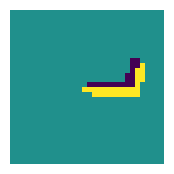

In [11]:
# Print a random SNN data from the training dataset

index = onp.random.randint(0, TRAIN_NUM_DATA * NUM_SNN_DATA)
print(index)
spike = torch.load(
    str(datasets_folder / "event_based_data" / "train" / f"spike{int(index)}.pt")
)
snn_animation(spike, str(outputs_dir / "snn_train_example.gif"))

339


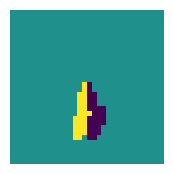

In [12]:
# Print a random SNN data from the test dataset

index = onp.random.randint(0, TEST_NUM_DATA * NUM_SNN_DATA)
print(index)
spike = torch.load(
    str(datasets_folder / "event_based_data" / "test" / f"spike{int(index)}.pt")
)
snn_animation(spike, str(outputs_dir / "snn_test_example.gif"))